In [1]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import pandas as pd

# Data Exploration, Visualization and Quality Assessment

As mention in the project intro, in the real project we have 2M samples but this data cannot be shared, I've extracted a 30M sample dataset that I used during the training process. 

The data exploration starts sampling the 2M dataset trying to keep the crop code distrutions, so the sample faithfully represents the original data. 

As you can see in the notebook, some of the crop categories has extreamly high apparition frequencies, to avoid problemas with the model, we oversample the less represented categories to keep a mininum sample size of 1000.
One crop category has been discarted because there's no enough data in the samples.


In [2]:
data_file = "/media/data/projects/crophisto/data.npy"
data = np.load(data_file)
y = data[:, 11]
X = data[:, :11]

In [3]:
print("Number of samples in the dataset: {}".format(y.shape[0]))

Number of samples in the dataset: 1984471


In [4]:
# last_year = X[:,-1]
# print("% of samples with crop change ni the last year: " + str(np.count_nonzero(y-last_year) / len(last_year)))

for i in range(3,11):
    diff = data[:,i]-data[:,i+1]
    print("% of samples with crop change in year {}: {}".format(i,(np.count_nonzero(diff))/ len(y)))



% of samples with crop change in year 3: 0.6504746101102007
% of samples with crop change in year 4: 0.6385268416620853
% of samples with crop change in year 5: 0.613958077492692
% of samples with crop change in year 6: 0.5880977852536016
% of samples with crop change in year 7: 0.7533604673487292
% of samples with crop change in year 8: 0.6276851614359696
% of samples with crop change in year 9: 0.6403651149349121
% of samples with crop change in year 10: 0.6265977179812655


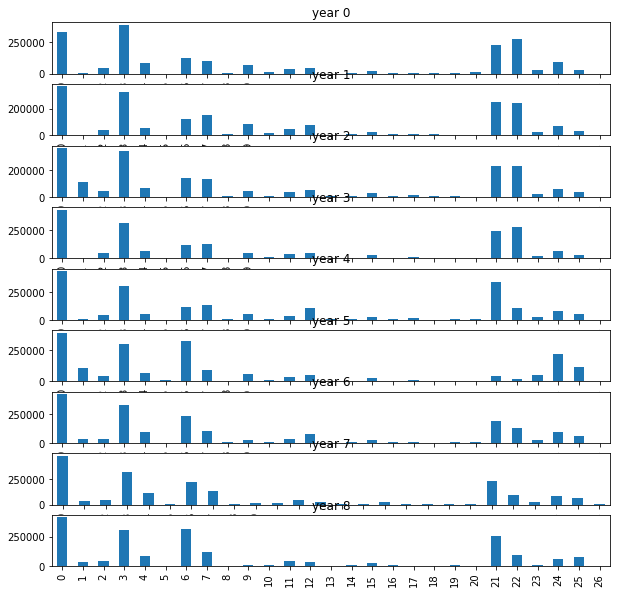

In [5]:
import warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(9, 1, figsize=(10, 10))

for i in range(9):
    axs[i].set_title("year {}".format(i))
    fig = pd.value_counts(data[:,3+i]).sort_index().plot(ax=axs[i],kind='bar')


The crop frequence is stable along the years.

In [6]:
# use StratifiedShuffleSplit from sklearn to keep data distributions

sample_size = 80000
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_test.shape)
print(y_test.shape)    

(80000, 11)
(80000,)


So now we have 15K dataset, lets see if the crop distributions are the same.

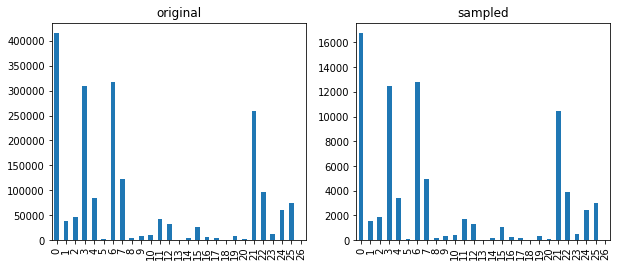

In [7]:
# find categories under represented
categories = np.sort(np.unique(y_test))

# freq1, bins1 = np.histogram(y, bins=categories)
# freq2, bins2 = np.histogram(y_test, bins=categories)

# fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# axs[0].hist(y_test,)
# axs[0].set_title("original")
# axs[1].hist(y,)
# axs[1].set_title("sampled")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_title("original")
axs[1].set_title("sampled")
fig = pd.value_counts(y).sort_index().plot(ax=axs[0],kind='bar')
fig = pd.value_counts(y_test).sort_index().plot(ax=axs[1],kind='bar')



As we can see, the categories are clearly unbalanced. This may suppose that the classifier tends to learn more accurately the patterns that the majority crops have as output, but those of less frequency won't are not adequately represented in the classifier hypothesis.
Although statistically this would make the classifier work "well", because in general terms it will give a good result if it hits the most representative classes, we are interested in that it is also capable of predicting other types of crops.

There are different techniques to deal with unbalanced groups (undersampling, oversampling, smote,) a library that implements this type of techniques and is of great help is [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html).

In this case, I have manually included a minimum of data for each category of crop. For each category, lest define the min number of samples as the 30% of the mean expected frequency, and calculate how many samples we have to add to each category.

Mean support: 2963, mean_frequency: 3.70%
Min support: 2000, min_frequency: 1.11%


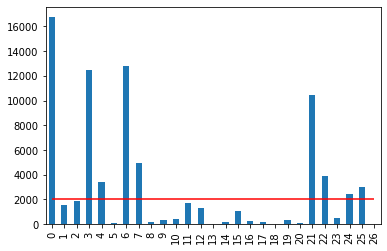

In [8]:
# find categories with less that min_size
num_categories = len(np.unique(y_test))
mean_frequency = (100/num_categories)/100 # porc
mean_support = round(sample_size * mean_frequency)
# min_frequency = mean_frequency * 0.15
min_frequency = mean_frequency * 0.30
min_support = 2000 #round(sample_size * min_frequency)
round(min_support)
print("Mean support: {}, mean_frequency: {:.2%}".format(mean_support, mean_frequency))
print("Min support: {}, min_frequency: {:.2%}".format(min_support, min_frequency))

# get frequency per category
categories = np.sort(np.unique(y_test))
freq_df = pd.DataFrame(y_test)
freq_df.columns = ["code"]
freq = freq_df["code"].value_counts().sort_index().values

fig = freq_df["code"].value_counts().sort_index().plot(kind='bar')
fig.hlines(min_support,0,max(y_test), colors="r")


In [9]:
y = data[:, 11]
X = data[:, :11]
last_year = X[:,-1]
print("Percentage of crops that have varied in the last year of the serie from the previous year: {} %".format(round(100*np.count_nonzero(last_year-y)/np.count_nonzero(y),2)))


Percentage of crops that have varied in the last year of the serie from the previous year: 79.27 %


In [10]:
print("Number of samples per category.")
print(categories)
print(freq)
print("Undersampled categories that need additional data.")

needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print(categories)

print("needed: \n{}".format(needed))


Number of samples per category.
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[16762  1515  1900 12454  3382    48 12766  4905   146   341   443  1729
  1286    25   200  1024   278   126    23   344   104 10428  3870   460
  2436  2991    14]
Undersampled categories that need additional data.
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
needed: 
[   0  485  100    0    0 1952    0    0 1854 1659 1557  271  714 1975
 1800  976 1722 1874 1977 1656 1896    0    0 1540    0    0 1986]


Now lets iterate through each category addind the needed data.

In [11]:
needed = (freq-min_support)
needed
needed[needed >0] = 0
needed = -1*needed
print("Initial dataset shape: {} ".format(X.shape))
y_over = y_test.copy()
X_over = X_test.copy()

data_copy = data[:, 3:11]

for index, needed_for_category in enumerate(needed):
    if needed_for_category == 0:
        continue
    category_code = categories[index]
    
    print("Adding {} samples for category {}".format(needed_for_category, category_code))
    # filter data for this category
    cat_mask = (y_train == category_code)
    
    # define the lower bound as the limit of samples to get from this category
    bound = min(needed_for_category, len(cat_mask == True))
    cat_y = y_train[cat_mask][:bound]
    y_over = np.hstack([y_over,cat_y])

    cat_X = X_train[cat_mask,:][:bound,:]
    X_over = np.vstack([X_over,cat_X])


dataset = np.hstack([X_over, y_over.reshape(-1,1)])
print("Final dataset shape: {}".format(dataset.shape))

Initial dataset shape: (1984471, 11) 
Adding 485 samples for category 1
Adding 100 samples for category 2
Adding 1952 samples for category 5
Adding 1854 samples for category 8
Adding 1659 samples for category 9
Adding 1557 samples for category 10
Adding 271 samples for category 11
Adding 714 samples for category 12
Adding 1975 samples for category 13
Adding 1800 samples for category 14
Adding 976 samples for category 15
Adding 1722 samples for category 16
Adding 1874 samples for category 17
Adding 1977 samples for category 18
Adding 1656 samples for category 19
Adding 1896 samples for category 20
Adding 1540 samples for category 23
Adding 1986 samples for category 26
Final dataset shape: (100726, 12)


Lets take a look at the final sample vs original distribution

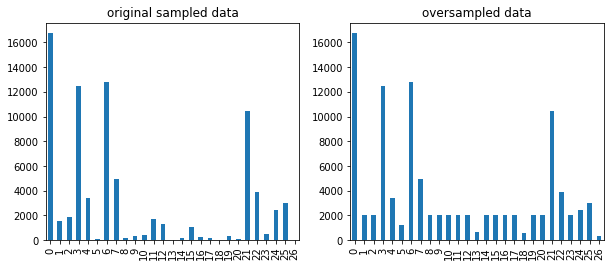

In [12]:
# get frequency per category
categories = np.sort(np.unique(y_test))
freq_df = pd.DataFrame(y_test)
freq_df.columns = ["code"]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_title("original sampled data")
axs[1].set_title("oversampled data")
pd.value_counts(y_test).sort_index().plot(ax=axs[0],kind='bar')
pd.value_counts(y_over).sort_index().plot(ax=axs[1],kind='bar')


As we can see, for some categories we don't haven enough data to get a mininum sample size, we are going to turn out samples that has category 255 in any year or in the y column.

In [13]:
np.unique(dataset[:,-1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [15]:
#save the data

# np.save("../resources/data_sampled_100K.npy", dataset)